# Insects classification with Resnet

A large part of this code is based on code from a fast.ai MOOC that will be publicly available in Jan 2019.

## Import library and set up batch size

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import os

In [3]:
#batch size starting from 64 (change it smaller later)
bs = 64

## Set up path and use images

In [4]:
cpath = os.getcwd()
cpath

'/home/jupyter/tutorials/fastai/course-v3/nbs/dl1'

In [5]:
path = os.path.join(cpath, "data/insects")
path

'/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/insects'

In [6]:
#some images are large so set max Image size (otherwise error message of DOS Bomb attack) and truncated images to be loaded
from PIL import Image, ImageFile
Image.MAX_IMAGE_PIXELS = 279257850*2
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.4, max_zoom=1.5, max_warp=0.4, p_affine=1., p_lighting=1.)

In [8]:
src = ImageItemList.from_folder(path, suffix='.jpg').random_split_by_pct(0.2, seed=2)

In [9]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs).normalize(imagenet_stats))

In [10]:
data = get_data(128, bs, 'zeros')

In [11]:
len(data.train_ds), len(data.valid_ds)

(27635, 6908)

In [12]:
data.c

129

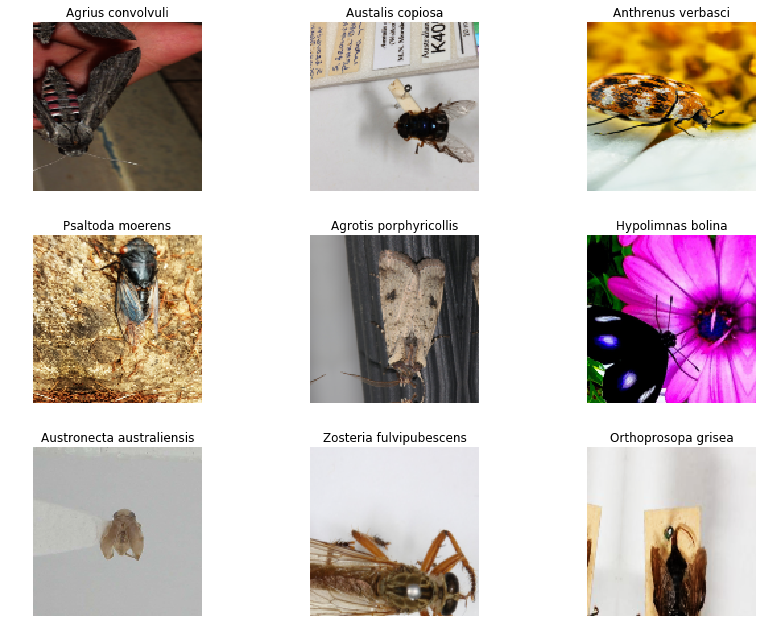

In [12]:
data.show_batch(rows=3, figsize=(12,9))

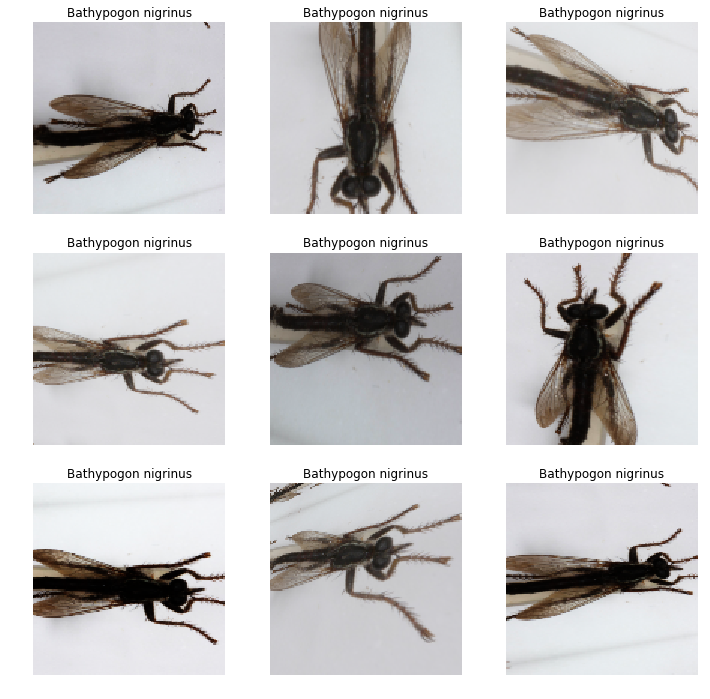

In [13]:
def _plot(i, j, ax):
    x, y = data.train_ds[0]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(12,12))    

## Create a model and train

In [11]:
# use resnet34
arch = models.resnet34

In [12]:
gc.collect()
# get accuracy and f1 score
learn = create_cnn(data, arch, metrics=error_rate, wd=1e-1, bn_final=True)

In [15]:
# learn.load('insects_resnet152_progsize_unfreeze_v1')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (27635 items)
[Category Bathypogon nigrinus, Category Bathypogon nigrinus, Category Bathypogon nigrinus, Category Bathypogon nigrinus, Category Bathypogon nigrinus]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/insects
x: ImageItemList (27635 items)
[Image (3, 2295, 1871), Image (3, 1799, 1306), Image (3, 2534, 3801), Image (3, 1619, 1137), Image (3, 1301, 1363)]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/insects;
Valid: LabelList
y: CategoryList (6908 items)
[Category Herpetogramma licarsisalis, Category Hermetia illucens, Category Austroargiolestes icteromelas, Category Eristalis tenax, Category Cosmodes elegans]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data/insects
x: ImageItemList (6908 items)
[Image (3, 1086, 1247), Image (3, 2132, 2111), Image (3, 1549, 2048), Image (3, 2278, 2031), Image (3, 1120, 887)]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


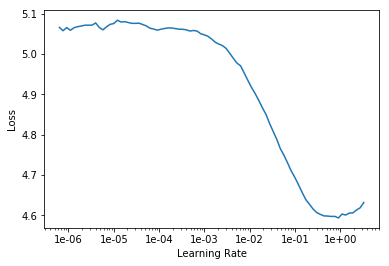

In [14]:
learn.recorder.plot()

In [15]:
# set learning rate based on the plot above (steepest point)
lr = 1e-2

In [16]:
learn.fit_one_cycle(2, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.832013,1.993242,0.496960
2,1.979966,1.398267,0.353214


In [17]:
learn.fit_one_cycle(5, slice(lr/10), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,1.885440,1.372214,0.342212
2,1.850320,1.328470,0.328170
3,1.726381,1.249726,0.313694
4,1.702761,1.192488,0.300376
5,1.648637,1.142093,0.292994


In [18]:
data = get_data(256, bs)
learn.data = data

In [19]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.818605,1.153212,0.276925
2,1.731741,1.074070,0.266792
3,1.691565,1.036822,0.257383
4,1.662849,1.018174,0.252027
5,1.655535,1.023832,0.254922


In [20]:
learn.save('Resnet34_Grad_CAM')

## Convolution kernel

In [22]:
data = get_data(256, 16)

In [24]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, wd=1e-1, bn_final=True).load('Resnet34_Grad_CAM')

Category Herpetogramma licarsisalis

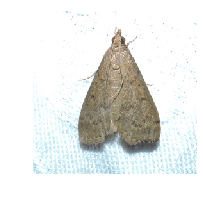

In [25]:
idx=0
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [19]:
k = tensor([
    [0., -5/3, 1.],
    [-5/3., 1., -5/3.],
    [1., -5/3., 0.],
]).expand(1,3,3,3)/6

In [26]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [27]:
from fastai.callbacks.hooks import *

In [28]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [29]:
k.shape

torch.Size([1, 3, 3, 3])

In [30]:
t = data.valid_ds[0][0].data
t.shape

torch.Size([3, 256, 256])

In [31]:
t[None].shape

torch.Size([1, 3, 256, 256])

In [32]:
edge = F.conv2d(t[None], k)

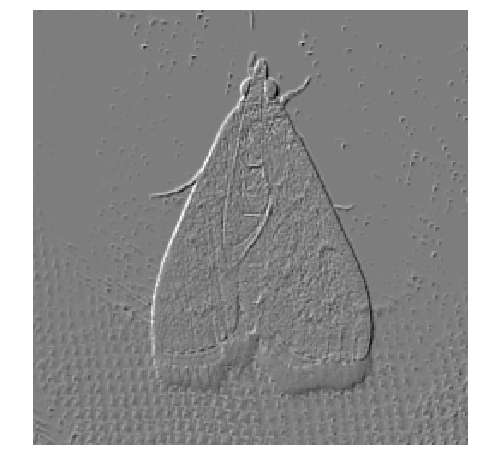

In [35]:
show_image(edge[0], figsize=(8, 8))

In [36]:
learn.summary()

Layer (type)               Output Shape         Param #   
Conv2d                    [16, 64, 128, 128]   9408                
________________________________________________________________________________
BatchNorm2d               [16, 64, 128, 128]   128                 
________________________________________________________________________________
ReLU                      [16, 64, 128, 128]   0                   
________________________________________________________________________________
MaxPool2d                 [16, 64, 64, 64]     0                   
________________________________________________________________________________
Conv2d                    [16, 64, 64, 64]     36864               
________________________________________________________________________________
BatchNorm2d               [16, 64, 64, 64]     128                 
________________________________________________________________________________
ReLU                      [16, 64, 64, 64]     

## Heatmap

In [37]:
m = learn.model.eval()

In [40]:
xb,_ = data.one_item(x)

In [65]:
data.denorm(xb)[0]

tensor([[[0.9807, 0.9879, 0.9940,  ..., 1.0000, 1.0000, 1.0000],
         [0.9995, 0.9983, 0.9992,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9996, 0.9983,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9144, 0.8414, 0.8499,  ..., 0.7477, 0.8145, 0.8345],
         [0.9119, 0.9027, 0.9226,  ..., 0.7168, 0.7817, 0.8380],
         [0.9077, 0.8903, 0.9122,  ..., 0.6254, 0.8133, 0.8623]],

        [[0.9956, 0.9983, 0.9990,  ..., 1.0000, 1.0000, 1.0000],
         [0.9995, 0.9983, 0.9992,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9987, 0.9983,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9968, 0.9460, 0.9533,  ..., 0.8518, 0.9075, 0.9343],
         [0.9986, 0.9990, 0.9990,  ..., 0.8323, 0.8766, 0.9302],
         [0.9987, 0.9877, 0.9975,  ..., 0.7472, 0.9105, 0.9654]],

        [[0.9936, 0.9982, 0.9984,  ..., 1.0000, 1.0000, 1.0000],
         [0.9995, 0.9983, 0.9992,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9996, 0.9983,  ..., 1.0000, 1.0000, 1.

In [89]:
xb_im = Image(data.denorm(xb)[0])

In [90]:
xb = xb.cuda()

In [91]:
from fastai.callbacks.hooks import*

In [96]:
preds = m(xb)
preds[0, int(y)]
preds[0], int(y), y

(tensor([ 1.5726,  1.4879,  1.0570,  1.8222,  0.2115,  0.2927, -1.4433,  0.0149,
          0.8959,  0.8132,  0.2464, -1.7801,  0.0088,  0.2131, -0.3249, -0.1402,
         -1.1235,  0.0233, -0.8377, -0.5388, -0.2474, -0.1918, -0.2477,  0.0174,
         -0.8566, -1.0561,  0.0402, -0.8388,  1.6589, -2.2986, -0.8004, -2.3949,
         -0.1991, -0.9391,  0.9573, -0.0281,  3.2315,  0.3737, -0.2435, -0.8541,
         -1.6554, -0.0294,  0.4658,  0.5791, -0.5383, -1.2907, -0.3439,  0.3067,
         -0.1566, -1.1198, -0.1241, -0.6373,  0.0275, -0.5825,  5.6017,  0.3386,
         -0.0593, -0.4635, -0.1317,  0.7232, -0.5841, -0.2919, -0.5386, -0.4497,
         -0.1303, -0.1468,  0.0264,  0.0712,  0.4176, -0.3372, -0.9104, -0.7591,
         -1.8206, -0.2270,  0.6577, -0.8039, -0.3306, -0.5408, -0.5975, -0.1470,
          0.1605, -0.7788, -0.3974, -0.9869, -0.9576, -0.2039, -0.6963,  1.2529,
         -0.2725,  1.8784,  2.1154, -0.7078, -1.1296, -0.6466, -0.5896,  0.9848,
         -0.3625, -0.6359,  

In [97]:
def hooked_backward(cat=y):
    # conv layers?
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [98]:
hook_a, hook_g = hooked_backward()

In [99]:
acts = hook_a.stored[0].cpu()
acts.shape #correct size of last ReLU

torch.Size([512, 8, 8])

In [100]:
avg_acts = acts.mean(0) #taking 2048 means of 8 * 8
avg_acts.shape

torch.Size([8, 8])

In [101]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0, 256, 256, 0),
             interpolation='bilinear', cmap='plasma')

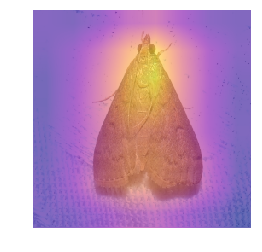

In [102]:
show_heatmap(avg_acts)

Grad-CAM localised where "Herpetogramma licarsisalis" is.